In [ ]:
from glob import glob
import os 
import json
import requests
from pyproj import Proj

from datetime import datetime
from pandas import concat, DataFrame, IndexSlice, read_csv
from numpy import sqrt, argsort, array

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set_style('white')

# Settings

In [ ]:
url_openstreetmap = "https://nominatim.openstreetmap.org/search"

In [ ]:
dir_geotop = 'data/GeoTOP_v01r6s1_csv_bestanden/'
dir_export = 'output/'

In [ ]:
save = False

In [ ]:
map_lithoclasses = dict({
    0: 'NaN', 1: 'veen', 2: 'klei', 3: 'kleiig_zand', 
    4: 'vervallen', 5: 'zand_fijn', 6: 'zand_matig_grof',
    7: 'zand_grof', 8: 'grind'
    })

In [ ]:
material_color_mapping = dict({
    'NaN': '#ffffff',
    'veen': '#64564c',
    'klei':'#b2a38d', 
    'kleiig_zand':'#8a8783', 
    'vervallen':'#ee82ee', 
    'zand_fijn':'#000000', 
    'zand_matig_grof': '#c5c5c5',  
    'zand_grof': '#616160',
    'grind': '#ffff82',
    'schelpen': '#eb611e' 
    })


In [ ]:
# crop to Rotterdam
#x_min, x_max = 56761, 101916
#y_min, y_max = 427675, 447090

# crop to Rotterdam centre
x_min, x_max = 89461, 96059
y_min, y_max = 432754, 438916

file_selection = ['B04', 'B05', 'B06', 'B07', 'B08', 'B09']

In [ ]:
user_input_address = None
data = DataFrame()
data_4to9 = DataFrame()

# Utils

In [ ]:
def get_data_for_rd_coordinates(x, y, data):
    df = data.loc[x, y, :].sort_index(ascending=False)
    
    df = df.copy()  # avoid SettingWithCopyWarning
    df['x'] = x
    df['y'] = y
    
    return df.reset_index()
    
def get_material_and_color_profile(datapoint, map_lithoclasses, material_color_mapping):
    datapoint['lithoclass_material'] = [map_lithoclasses[lithoclass] for lithoclass in datapoint.lithoklasse]
    
    datapoint.loc[:, 'color_lithoclass_material'] = [
        material_color_mapping[datapoint.loc[z, 'lithoclass_material']] for z in datapoint.index
        ]

    return datapoint

In [ ]:
def find_closest_point_to_input(x_target, y_target, data):

    xy = array(data.index.droplevel('z').unique().tolist()) 
    distances = sqrt((xy[:, 0] - x_target)**2 + (xy[:, 1] - y_target)**2)
    sorted_indices = argsort(distances)

    closest_xy = xy[sorted_indices[0]]

    second_closest_xy = xy[sorted_indices[1]]
    third_closest_xy = xy[sorted_indices[2]]

    print("Closest:", closest_xy)
    print("Second closest:", second_closest_xy)
    print("Third closest:", third_closest_xy)

    return [closest_xy, second_closest_xy, third_closest_xy]


def find_box_around_input(x_target, y_target, data):

    xy = array(data.index.droplevel('z').unique().tolist())

    distances = sqrt((xy[:, 0] - x_target)**2 + (xy[:, 1] - y_target)**2)
    sorted_indices = argsort(distances)
    closest_xy = xy[sorted_indices[0]]
    print("Closest:", closest_xy)

    dx = dy = 100
    x_min, x_max = closest_xy[0] - dx, closest_xy[0] + dx
    y_min, y_max = closest_xy[1] - dy, closest_xy[1] + dy

    mask = (xy[:, 0] >= x_min) & (xy[:, 0] <= x_max) & (xy[:, 1] >= y_min) & (xy[:, 1] <= y_max)
    points_in_box = xy[mask]

    print("Points within box:", points_in_box)
    return points_in_box

In [ ]:
def plot_3D_projection_datapoints(profiles, columns_selection, figsize=(10,8)):

    color_column = [col for col in columns_selection if 'color' in col]
    if len(color_column)!= 1:
        print('failed to identify color for material!')
    else:
        color_column = color_column[0]

    material_column = [col for col in columns_selection if 'material' in col and 'color' not in col]
    if len(material_column)!= 1:
        print('failed to identify material!')
    else:
        material_column = material_column[0]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    material_colors = {}

    for profile in profiles:
        df = profile[columns_selection].sort_index(ascending=False)

        xs = df['x'].values
        ys = df['y'].values
        zs = df.index.values    
        cs = df[color_column].values

        ax.scatter(xs, ys, zs, c=cs, s=100, depthshade=True)

        for mat, col in zip(df[material_column], df[color_column]):
            material_colors[mat] = col

    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Depth (m)")

    ax.set_zlim(ax.get_zlim()[::-1])

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=mat, markerfacecolor=color, markersize=8)
        for mat, color in material_colors.items()
        ]
    ax.legend(handles=handles, title=material_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"3D Geological Profiles for RD coordinates {int(x)},{int(y)}", pad=20)
    plt.tight_layout()

    return fig

# User Input

In [ ]:
user_input_address = "Depot Boijmans Van Beuningen"

## Get RD coordinates from Address

### get geometric coordinates for address

In [ ]:
if not user_input_address:
    latitude, longitude = 51.9139529, 4.4711320
    print(f"No user input defined; fall back to default: {latitude}, {longitude} (lat, lon)")

else:
    try:
        geo = requests.get(
            url_openstreetmap, 
            headers={"User-Agent": "CaraLogic (contact: silvia@caralogic.com)"}, 
            params={"q": user_input_address, "format": "json", "limit": 1}
            )

        geo.raise_for_status()
        if len(geo.json()) == 0:
            print(f"no data found for {user_input_address}")
            latitude, longitude = None, None
        else:  
            location = geo.json()[0]
            latitude, longitude = location['lat'], location['lon']  
    except:
        latitude, longitude = 51.9139529, 4.4711320

    print(f"Coordinates found for {user_input_address}: {latitude}, {longitude} (lat, lon)")


Coordinates found for Depot Boijmans Van Beuningen: 51.9139529, 4.4711320 (lat, lon)


### convert to RD coordinates

In [ ]:
rd = Proj('epsg:28992')

x, y = rd(longitude, latitude)

print(f"RD coordinates in meter: x(east)={x}, y(north)={y}")
# !!!ToDO: check projection. Reference says 92345, 436705 or 91973, 436559

RD coordinates in meter: x(east)=91949.9085131148, y(north)=436453.13855728577


# Import GeoTop data

### import all data

In [ ]:
ls_files = sorted([file for file in glob(dir_geotop + '*.csv')])
ls_files

['data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B01.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B02.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B03.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B04.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B05.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B06.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B07.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B08.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B09.csv']

In [ ]:
ls_data = [read_csv(file, index_col=[0,1,2]) for file in ls_files]

data = concat(ls_data).sort_index()
data.head(10)

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
x       y        z                                                           
58550.0 437550.0 -49.75        5120            6         0.00         0.17   
                 -49.25        5120            6         0.00         0.24   
                 -48.75        5120            6         0.02         0.17   
                 -48.25        5120            6         0.04         0.24   
                 -47.75        5120            1         0.06         0.21   
                 -47.25        5120            6         0.04         0.13   
                 -46.75        5120            6         0.02         0.13   
                 -46.25        5120            2         0.02         0.27   
                 -45.75        5120            5         0.02         0.25   
                 -45.25        5120            6         0.02         0.25   

                         kans_3_kleiig_zand  kans_4_vervallen  \
x       y        z                                              
58550.0 437550.0 -49.75                0.23               0.0   
                 -49.25                0.26               0.0   
                 -48.75                0.31               0.0   
                 -48.25                0.32               0.0   
                 -47.75                0.33               0.0   
                 -47.25                0.23               0.0   
                 -46.75                0.15               0.0   
                 -46.25                0.21               0.0   
                 -45.75                0.33               0.0   
                 -45.25                0.33               0.0   

                         kans_5_zand_fijn  kans_6_zand_matig_grof  \
x       y        z                                                  
58550.0 437550.0 -49.75              0.24                    0.28   
                 -49.25              0.18                    0.24   
                 -48.75              0.18                    0.25   
                 -48.25              0.15                    0.19   
                 -47.75              0.05                    0.27   
                 -47.25              0.22                    0.28   
                 -46.75              0.30                    0.29   
                 -46.25              0.23                    0.18   
                 -45.75              0.19                    0.15   
                 -45.25              0.16                    0.17   

                         kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
x       y        z                                                         
58550.0 437550.0 -49.75              0.08           0.0              0.0   
                 -49.25              0.08           0.0              0.0   
                 -48.75              0.07           0.0              0.0   
                 -48.25              0.06           0.0              0.0   
                 -47.75              0.08           0.0              0.0   
                 -47.25              0.10           0.0              0.0   
                 -46.75              0.11           0.0              0.0   
                 -46.25              0.09           0.0              0.0   
                 -45.75              0.06           0.0              0.0   
                 -45.25              0.07           0.0              0.0   

                         modelonzekerheid_lithoklasse  \
x       y        z                                      
58550.0 437550.0 -49.75                          0.86   
                 -49.25                          0.86   
                 -48.75                          0.88   
                 -48.25                          0.90   
                 -47.75                          0.87   
                 -47.25                          0.92   
                 -46.75                          0.89   
                 -46.25                          0.9

### import selected files

In [ ]:
ls_files_selected = []
for file in ls_files:
    file_nr = (int(file.split('_B0')[1].split('.csv')[0]))
    if file.split('_')[-1].split('.csv')[0] in file_selection:
        ls_files_selected.append(file)

ls_files_selected

['data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B04.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B05.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B06.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B07.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B08.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B09.csv']

In [ ]:
ls_data_4to9 = [read_csv(file, index_col=[0,1,2]) for file in ls_files_selected]

data_4to9 = concat(ls_data_4to9).sort_index()
data_4to9.head(10)

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
x       y        z                                                           
58550.0 437550.0 -49.75        5120            6         0.00         0.17   
                 -49.25        5120            6         0.00         0.24   
                 -48.75        5120            6         0.02         0.17   
                 -48.25        5120            6         0.04         0.24   
                 -47.75        5120            1         0.06         0.21   
                 -47.25        5120            6         0.04         0.13   
                 -46.75        5120            6         0.02         0.13   
                 -46.25        5120            2         0.02         0.27   
                 -45.75        5120            5         0.02         0.25   
                 -45.25        5120            6         0.02         0.25   

                         kans_3_kleiig_zand  kans_4_vervallen  \
x       y        z                                              
58550.0 437550.0 -49.75                0.23               0.0   
                 -49.25                0.26               0.0   
                 -48.75                0.31               0.0   
                 -48.25                0.32               0.0   
                 -47.75                0.33               0.0   
                 -47.25                0.23               0.0   
                 -46.75                0.15               0.0   
                 -46.25                0.21               0.0   
                 -45.75                0.33               0.0   
                 -45.25                0.33               0.0   

                         kans_5_zand_fijn  kans_6_zand_matig_grof  \
x       y        z                                                  
58550.0 437550.0 -49.75              0.24                    0.28   
                 -49.25              0.18                    0.24   
                 -48.75              0.18                    0.25   
                 -48.25              0.15                    0.19   
                 -47.75              0.05                    0.27   
                 -47.25              0.22                    0.28   
                 -46.75              0.30                    0.29   
                 -46.25              0.23                    0.18   
                 -45.75              0.19                    0.15   
                 -45.25              0.16                    0.17   

                         kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
x       y        z                                                         
58550.0 437550.0 -49.75              0.08           0.0              0.0   
                 -49.25              0.08           0.0              0.0   
                 -48.75              0.07           0.0              0.0   
                 -48.25              0.06           0.0              0.0   
                 -47.75              0.08           0.0              0.0   
                 -47.25              0.10           0.0              0.0   
                 -46.75              0.11           0.0              0.0   
                 -46.25              0.09           0.0              0.0   
                 -45.75              0.06           0.0              0.0   
                 -45.25              0.07           0.0              0.0   

                         modelonzekerheid_lithoklasse  \
x       y        z                                      
58550.0 437550.0 -49.75                          0.86   
                 -49.25                          0.86   
                 -48.75                          0.88   
                 -48.25                          0.90   
                 -47.75                          0.87   
                 -47.25                          0.92   
                 -46.75                          0.89   
                 -46.25                          0.9

In [ ]:
if not data.empty and not data_4to9.empty:
    print(f"{data.shape} vs {data_4to9.shape} (cropped)")

(24874929, 13) vs (16969664, 13) (cropped)


# Find data points in dataset from input

### find closest point in dataset

In [ ]:
points_nearest = find_closest_point_to_input(x,y, data)

Closest: [ 91950. 436450.]
Second closest: [ 91950. 436550.]
Third closest: [ 91850. 436450.]


### get box around address 

In [ ]:
points_in_box = find_box_around_input(x, y, data)

Closest: [ 91950. 436450.]
Points within box: [[ 91850. 436350.]
 [ 91850. 436450.]
 [ 91850. 436550.]
 [ 91950. 436350.]
 [ 91950. 436450.]
 [ 91950. 436550.]
 [ 92050. 436350.]
 [ 92050. 436450.]
 [ 92050. 436550.]]


### get profiles for data points

In [ ]:
datapoints = [get_data_for_rd_coordinates(rd_closest[0], rd_closest[1], data) for rd_closest in points_in_box]

In [ ]:
profiles = [
    get_material_and_color_profile(datapoint, map_lithoclasses, material_color_mapping) for datapoint in datapoints
    ]

In [ ]:
profile_per_datapoint = [
    profile[['x', 'y', 'z', 'lithoclass_material', 'color_lithoclass_material']].set_index('z') 
    for profile in profiles
    ]

# Data Vis 3D Projection

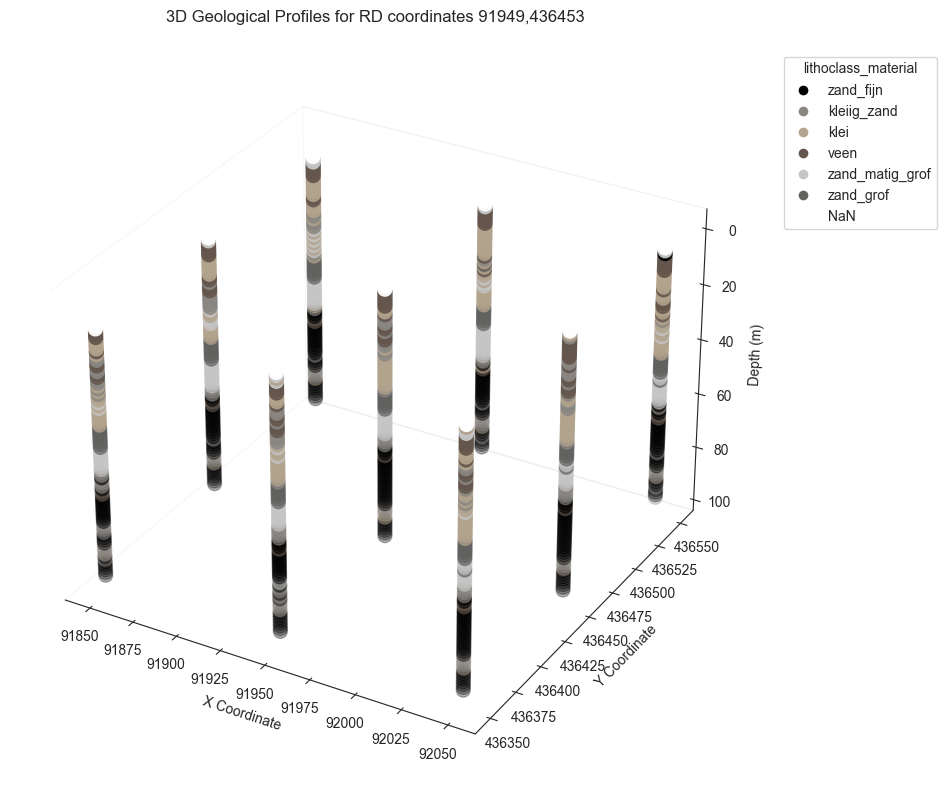

In [ ]:
fig = plot_3D_projection_datapoints(
    profiles=profiles, 
    columns_selection=['x', 'y', 'lithoclass_material', 'color_lithoclass_material'], 
    figsize=(10,8)
    )


if save:
    fig.savefig(
    f"3D_geological_profiles_box_for_{int(x)}_{int(y)}.png", dpi=600, bbox_inches="tight", transparent=True       
    )
plt.show()

# Output as JSON

### prepare for output

In [ ]:
lithoclass_material = data_4to9['lithoklasse'].map(map_lithoclasses)
data_4to9['lithoclass_material'] = lithoclass_material

In [ ]:
idx = IndexSlice
cropped = data_4to9.loc[idx[x_min:x_max, y_min:y_max, :], :].sort_index()
print(f"Reduced shape to {cropped.shape} compared to {data_4to9.shape}")

Reduced shape to (391956, 14) compared to (16969664, 14)


In [ ]:
selected_columns = [
    'x', 'y', 'z', 'lithoklasse', 'lithoclass_material', 
    'kans_1_veen', 'kans_2_klei', 'kans_3_kleiig_zand', 'kans_4_vervallen', 'kans_5_zand_fijn',
    'kans_6_zand_matig_grof', 'kans_7_zand_grof', 'kans_8_grind', 'kans_9_schelpen'
]

cropped = cropped.reset_index()[selected_columns]
cropped.rename(columns={
    'lithoklasse':'lithoklasse_id', 
    'lithoclass_material':'lithoklasse_materiaal'
    }, inplace=True)

cropped

,x,y,z,lithoklasse_id,lithoklasse_materiaal,kans_1_veen,kans_2_klei,kans_3_kleiig_zand,kans_4_vervallen,kans_5_zand_fijn,kans_6_zand_matig_grof,kans_7_zand_grof,kans_8_grind,kans_9_schelpen
0,89550.0,432850.0,-49.75,3,kleiig_zand,0.01,0.18,0.31,0.0,0.13,0.29,0.08,0.0,0.0
1,89550.0,432850.0,-49.25,2,klei,0.01,0.23,0.26,0.0,0.17,0.26,0.07,0.0,0.0
2,89550.0,432850.0,-48.75,6,zand_matig_grof,0.01,0.14,0.25,0.0,0.22,0.30,0.08,0.0,0.0
3,89550.0,432850.0,-48.25,5,zand_fijn,0.03,0.16,0.21,0.0,0.25,0.24,0.11,0.0,0.0
4,89550.0,432850.0,-47.75,2,klei,0.04,0.24,0.32,0.0,0.11,0.23,0.06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391951,96050.0,438850.0,-6.75,1,veen,0.90,0.10,0.00,0.0,0.00,0.00,0.00,0.0,0.0
391952,96050.0,438850.0,-6.25,1,veen,0.98,0.02,0.00,0.0,0.00,0.00,0.00,0.0,0.0
391953,96050.0,438850.0,-5.75,2,klei,0.13,0.72,0.15,0.0,0.00,0.00,0.00,0.0,0.0
391954,96050.0,438850.0,-5.25,2,klei,0.03,0.79,0.18,0.0,0.00,0.00,0.00,0.0,0.0


In [ ]:
profiled = cropped.groupby(['x', 'y']).apply(
    lambda g: sorted(g.to_dict(orient='records'), key=lambda d: d['z'], reverse=True)
).reset_index(name='data')

list_of_lists = profiled['data'].tolist()

/var/folders/lx/z70mzvpx4ls9np3hfbhll4wr0000gn/T/ipykernel_50074/1709030631.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  profiled = cropped.groupby(['x', 'y']).apply(


### export all data in one file

for all data points, describe the identified lithoclass (through mapping) and select likelihood of all material being present 

In [ ]:
base_name = f"B04-to-B09_lithoclass_materials_and_likelihood"
name_file =  f"_{x_min}-{x_max}_{y_min}-{y_max}_{datetime.now().date().isoformat()}.json"
file_path = dir_export + base_name + name_file

with open(file_path, 'w') as f:
    json.dump(list_of_lists, f)

print(f"stored {file_path}")

stored output/B04-to-B09_lithoclass_materials_and_likelihood_89461-96059_432754-438916_2025-11-12.json


### export in batches

In [ ]:
MAX_BYTES = 5 * 1024 * 1024  # 5 MB

batch = []
batch_size = 0
file_index = 1

output_dir = dir_export + f"json_5MB_chunks/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for sublist in list_of_lists:
    sublist_bytes = len(json.dumps(sublist, separators=(',', ':')).encode('utf-8'))

    if batch_size + sublist_bytes > MAX_BYTES and batch:
        file_name = os.path.join(output_dir, f"litho_batch_{file_index}.json")
        with open(file_name, 'w') as f:
            json.dump(batch, f, separators=(',', ':'))
        print(f"Stored {file_name} ({batch_size / 1024**2:.2f} MB)")

        file_index += 1
        batch = []
        batch_size = 0

    batch.append(sublist)
    batch_size += sublist_bytes

if batch:
    file_name = os.path.join(output_dir, f"litho_batch_{file_index}.json")
    with open(file_name, 'w') as f:
        json.dump(batch, f, separators=(',', ':'))
    print(f"Stored {file_name} ({batch_size / 1024**2:.2f} MB)")

Stored output/json_5MB_chunks/litho_batch_1.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_2.json (4.98 MB)
Stored output/json_5MB_chunks/litho_batch_3.json (4.98 MB)
Stored output/json_5MB_chunks/litho_batch_4.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_5.json (4.98 MB)
Stored output/json_5MB_chunks/litho_batch_6.json (4.98 MB)
Stored output/json_5MB_chunks/litho_batch_7.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_8.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_9.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_10.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_11.json (4.97 MB)
Stored output/json_5MB_chunks/litho_batch_12.json (5.00 MB)
Stored output/json_5MB_chunks/litho_batch_13.json (4.98 MB)
Stored output/json_5MB_chunks/litho_batch_14.json (4.98 MB)
Stored output/json_5MB_chunks/litho_batch_15.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_16.json (4.99 MB)
Stored output/json_5MB_chunks/litho_batch_17.json

# Read JSON

In [ ]:
output_dir = 'output/json_5MB_chunks/'

In [ ]:
ls_files_for_read = [file for file in glob(output_dir + '*.json')]

In [ ]:
ls_df = []
for path in ls_files_for_read:
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        print(f"Reading {path}")

        dfs = []

        for f_sub in data:
            if isinstance(f_sub, list):
                if len(f_sub) > 0 and isinstance(f_sub[0], dict):
                    dfs.append(DataFrame(f_sub))
                else:
                    dfs.append(DataFrame({"value": f_sub}))
            
            elif isinstance(f_sub, dict):
                dfs.append(DataFrame([f_sub]))

            else:
                dfs.append(DataFrame({"value": [f_sub]}))

        file_df = concat(dfs, ignore_index=True)
        ls_df.append(file_df)


df_import = concat(ls_df)

Reading output/json_5MB_chunks/litho_batch_15.json
Reading output/json_5MB_chunks/litho_batch_23.json
Reading output/json_5MB_chunks/litho_batch_19.json
Reading output/json_5MB_chunks/litho_batch_6.json
Reading output/json_5MB_chunks/litho_batch_7.json
Reading output/json_5MB_chunks/litho_batch_18.json
Reading output/json_5MB_chunks/litho_batch_22.json
Reading output/json_5MB_chunks/litho_batch_14.json
Reading output/json_5MB_chunks/litho_batch_25.json
Reading output/json_5MB_chunks/litho_batch_13.json
Reading output/json_5MB_chunks/litho_batch_12.json
Reading output/json_5MB_chunks/litho_batch_1.json
Reading output/json_5MB_chunks/litho_batch_24.json
Reading output/json_5MB_chunks/litho_batch_2.json
Reading output/json_5MB_chunks/litho_batch_11.json
Reading output/json_5MB_chunks/litho_batch_10.json
Reading output/json_5MB_chunks/litho_batch_3.json
Reading output/json_5MB_chunks/litho_batch_17.json
Reading output/json_5MB_chunks/litho_batch_8.json
Reading output/json_5MB_chunks/litho_

In [ ]:
print(
    f"comparing shapes of datasets:"
    f"\n original dataset: {cropped.shape},"
    f"\n re-imported dataset: {df_import.shape} and"
    f"\n duplicated removed: {df_import.drop_duplicates().shape}")

comparing shapes of datasets:
 original dataset: (391956, 14),
 re-imported dataset: (409507, 14) and duplicated removed: (391956, 14)
